In [42]:
import numpy as np
import os
import re
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import plotly.express as px

In [43]:
PATH_ANNOTATED = 'radar_camera_annoted.txt'

In [44]:
with open(PATH_ANNOTATED, "r") as f:
    lines = f.readlines()

    # loading paths
    path_annoted = [l.split()[0] for l in lines]

In [45]:
len(path_annoted)

1556

In [46]:
a = np.load('camera_annoted'+path_annoted[22], allow_pickle=True)["camera_annotation"]
b = np.load('radar_annoted'+path_annoted[22], allow_pickle=True)["annotation_matrix"]
c = np.load('radar_annoted'+path_annoted[22], allow_pickle=True)["labels"]

In [47]:
b.shape

(6, 1025, 1025)

In [48]:
print(c)

[13012 13011 13010 13009 13008 13007]


<Figure size 432x288 with 0 Axes>

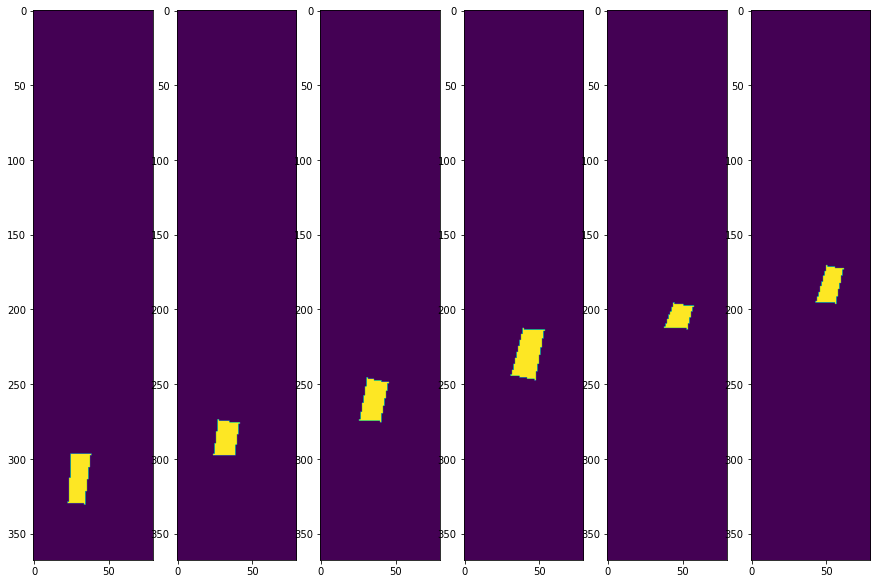

In [49]:
plt.figure()
f, axarr = plt.subplots(1,6, figsize=(15, 15))

for i in range(6):
        axarr[i].imshow(b[i, 152:-505, 465:-480])

In [50]:
(a==c[0]).astype(int).shape

(1024, 1280)

<Figure size 432x288 with 0 Axes>

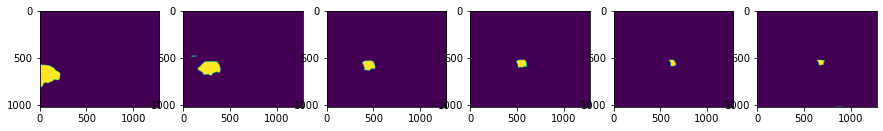

In [51]:
plt.figure()
f, axarr = plt.subplots(1,6, figsize=(15, 15))

for i in range(6):
        axarr[i].imshow((a==c[i]).astype(int))

In [52]:
def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    #img[ymin:ymax+1, xmin:xmax+1]
    return img[ymin:ymax+1, xmin:xmax+1]

In [53]:
test = bbox2(((a==13008)*255).astype(np.uint8))

In [54]:
np.count_nonzero(test)

3449

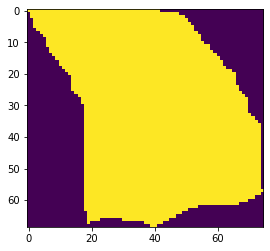

In [55]:
plt.figure()
plt.imshow(test)

In [56]:
test.shape[0]*test.shape[1]

5175

In [57]:
def bounding_box(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    #img[ymin:ymax+1, xmin:xmax+1]
    return ymax, ymin, xmax, xmin

In [58]:
array_camera_annoted = []
array_radar_annoted = []
count_bug_seg = 0
count_crop = 0
for i in range(0, len(path_annoted)):
    #annoted
    camera = np.load('camera_annoted'+path_annoted[i], allow_pickle=True)["camera_annotation"]
    radar = np.load('radar_annoted'+path_annoted[i], allow_pickle=True)["annotation_matrix"]
    annotation = np.load('radar_annoted'+path_annoted[i], allow_pickle=True)["labels"]
    for j in range(annotation.shape[0]):
        # 4 points
        image_camera = ((camera==annotation[j])*255).astype(np.uint8)
        if(np.count_nonzero(radar[j, 152:-505, 465:-480]!=0)>0):
            image_radar = radar[j, 152:-505, 465:-480]
            ymax_rad, ymin_rad, xmax_rad, xmin_rad = bounding_box(image_radar)
            ymax_cam, ymin_cam, xmax_cam, xmin_cam = bounding_box(image_camera)
            
            crop_camera = image_camera[ymin_cam:ymax_cam+1, xmin_cam:xmax_cam+1]
            # check legitimate bounding box
            if(np.count_nonzero(crop_camera) > 0.5*crop_camera.shape[0]*crop_camera.shape[1]):
                array_radar_annoted.append([ymax_rad, ymin_rad, xmax_rad, xmin_rad])
                array_camera_annoted.append([ymax_cam, ymin_cam, xmax_cam, xmin_cam])
                im = Image.fromarray(image_radar[ymin_rad:ymax_rad+1, xmin_rad:xmax_rad+1].astype(np.uint8))
                im.save("radar_crop/"+str(i)+str(ymin_rad)+".jpeg")
                im = Image.fromarray(crop_camera)
                #[ymin_cam:ymax_cam+1, xmin_cam:xmax_cam+1].astype(np.uint64)
                im.save("camera_crop/"+str(i)+str(ymax_cam)+".jpeg")
            else:
                count_bug_seg+=1
        else:
            count_crop+=1

array_camera_annoted = np.array(array_camera_annoted)
array_radar_annoted = np.array(array_radar_annoted)

In [ ]:
'''im = Image.fromarray(radar[j, ymin_rad+152:ymax_rad+1-505, xmin_rad+465:xmax_rad-480+1].astype(np.uint8))
                im.save("radar_crop/"+str(i)+".jpeg")
                im = Image.fromarray(image_camera[ymin_cam:ymax_cam+1, xmin_cam:xmax_cam+1])
                [ymin_cam:ymax_cam+1, xmin_cam:xmax_cam+1].astype(np.uint64)
                im.save("camera_crop/"+str(i)+".jpeg")'''

In [59]:
array_camera_annoted[0].shape

(4,)

In [60]:
array_radar_annoted.shape

(2065, 4)

In [61]:
print(count_bug_seg)
print(count_crop)

1975
614


In [62]:
np.save("bbox_camera_04.npy", array_camera_annoted)
np.save("bbox_radar_04.npy", array_radar_annoted)